## Amini Solution Architect EDA notebook

### Task
**Create a comprehensive climate risk profile for Admin 3 levels for one Admin 1 level (Eigeyo Marakwet County) in Kenya**
- To develop an integrated hazard and exposure risk
- To develop climate profiles for the different admin 3 levels
- To provide recommendations for risk mitigation

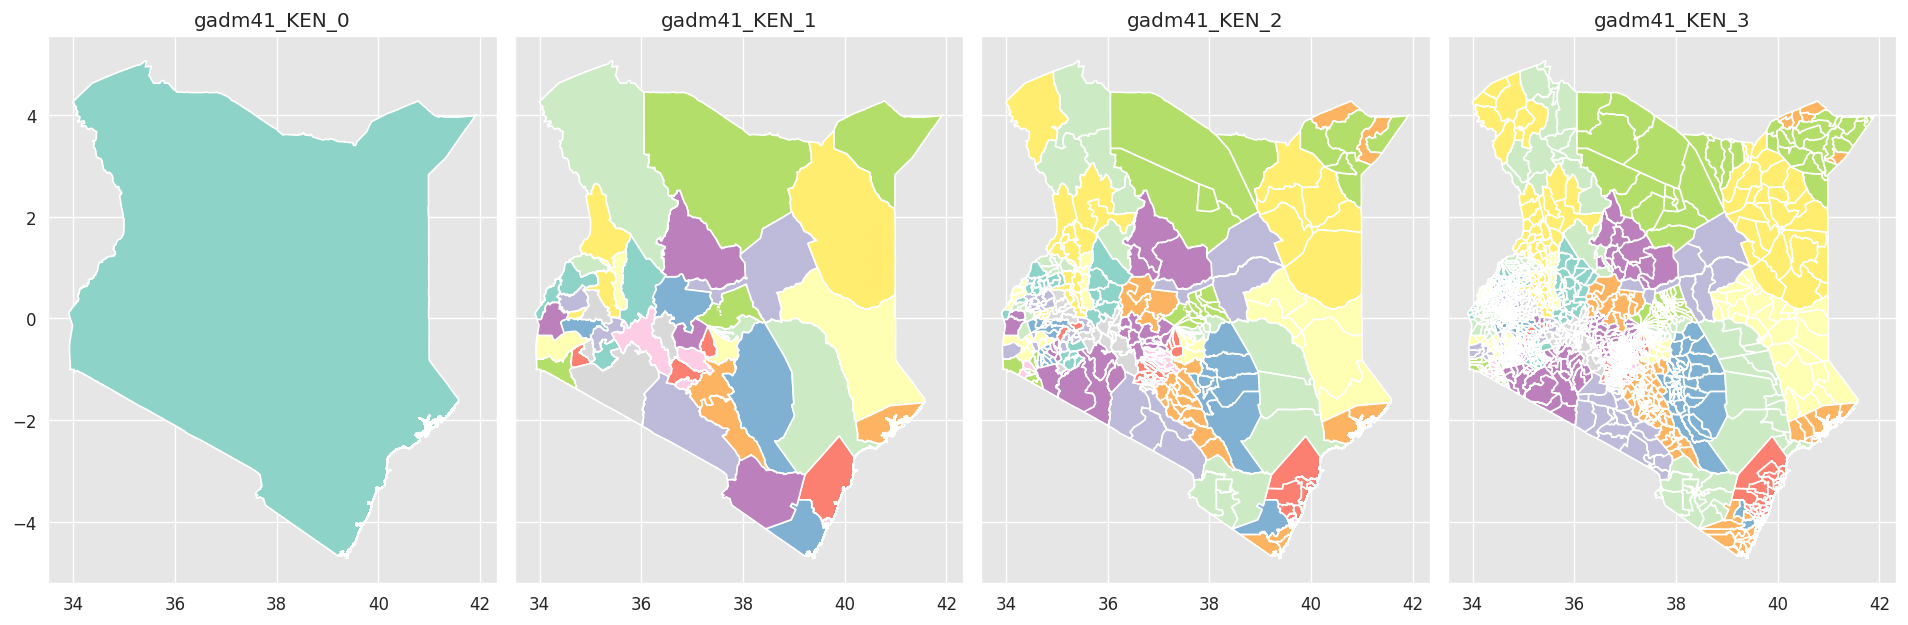

In [83]:
#######################################
#Amini Solution Architect EDA notebook#
#Maintainer: Christopher Chan         #
#Version: 0.1.0                       #
#Date: 2025-03-15                     #
#######################################

import os
from datetime import datetime
from glob import glob
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import seaborn as sns
from dateutil.relativedelta import relativedelta
from rasterio.mask import mask
from rasterio.plot import show, show_hist

%matplotlib inline

# Set consistent figure style and size
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 120
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

data_raw = Path('../data/01_raw')
data_intermediate = Path('../data/02_intermediate')
data_features = Path('../data/04_feature')

fig, ax = plt.subplots(1, 4, figsize=(16, 8), sharey=True)

for i, file in enumerate(sorted(glob(f"{data_raw}/vector/gadm41_KEN_shp/*.shp"))):
    gdf = gpd.read_file(file)
    gdf.plot(ax=ax[i], cmap='Set3')
    ax[i].set_title(Path(file).stem)

plt.tight_layout()
plt.show()

In [2]:
# Init GEE
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='amini-sa')

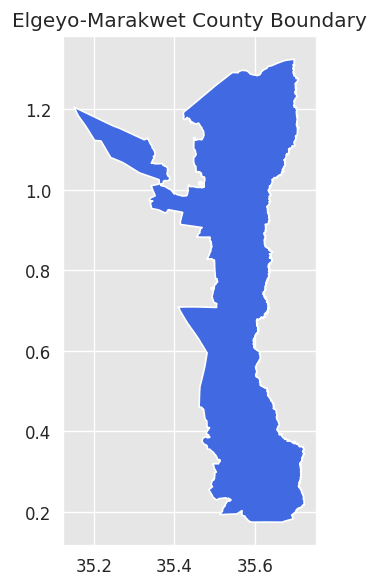

In [85]:
# Get Kenya boundary
Kenya_gpd = gpd.read_file(f"{data_raw}/vector/gadm41_KEN_shp/gadm41_KEN_1.shp").to_crs(epsg=4326)
# Get Elgeyo Marakwet County boundary
EMC1_gpd = Kenya_gpd[Kenya_gpd['NAME_1'] == 'Elgeyo-Marakwet']

# Write to file
os.makedirs(f"{data_intermediate}/vector", exist_ok=True)
EMC1_gpd.to_file(f"{data_intermediate}/vector/EMC1_gpd.geojson", driver='GeoJSON')

# Plot with better aspect ratio
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
EMC1_gpd.plot(ax=ax, color='royalblue')
ax.set_title('Elgeyo-Marakwet County Boundary')
plt.tight_layout()
plt.show()

In [4]:
# Merging multiple EMC boundaries into one
ee_EMC_bound = geemap.gdf_to_ee(EMC1_gpd)

### Drought Hazard Exposure Raw Data
- Combination of SMAP L3 and SPEI from GEE

In [5]:
## 48 months average SMAP
date_now = datetime.now().date().isoformat()
date_48 = (datetime.now() - relativedelta(months=48)).date().isoformat()

# Get raster
SMAP_mean = (ee.ImageCollection("NASA/SMAP/SPL3SMP_E/006")
          .filterDate(date_48, date_now)
          .filterBounds(ee_EMC_bound.geometry())
          .select('soil_moisture_am')
          .mean())

SPEI_mean = (ee.ImageCollection("CSIC/SPEI/2_10")
          .filterDate(date_48, date_now)
          .filterBounds(ee_EMC_bound.geometry())
          .select('SPEI_48_month')
          .mean())

os.makedirs(f"{data_raw}/raster", exist_ok=True)
geemap.ee_export_image(SMAP_mean, region=ee_EMC_bound.geometry(), filename=f"{data_raw}/raster/SMAP_mean.tif")
geemap.ee_export_image(SPEI_mean, region=ee_EMC_bound.geometry(), filename=f"{data_raw}/raster/SPEI_mean.tif")

Generating URL ...
Please wait ...
Data downloaded to /home/chris/mnt1/Proj/amini-sa/data/01_raw/raster/SMAP_mean.tif
Generating URL ...
Please wait ...
Data downloaded to /home/chris/mnt1/Proj/amini-sa/data/01_raw/raster/SPEI_mean.tif


Text(0.5, 1.0, 'SPEI')

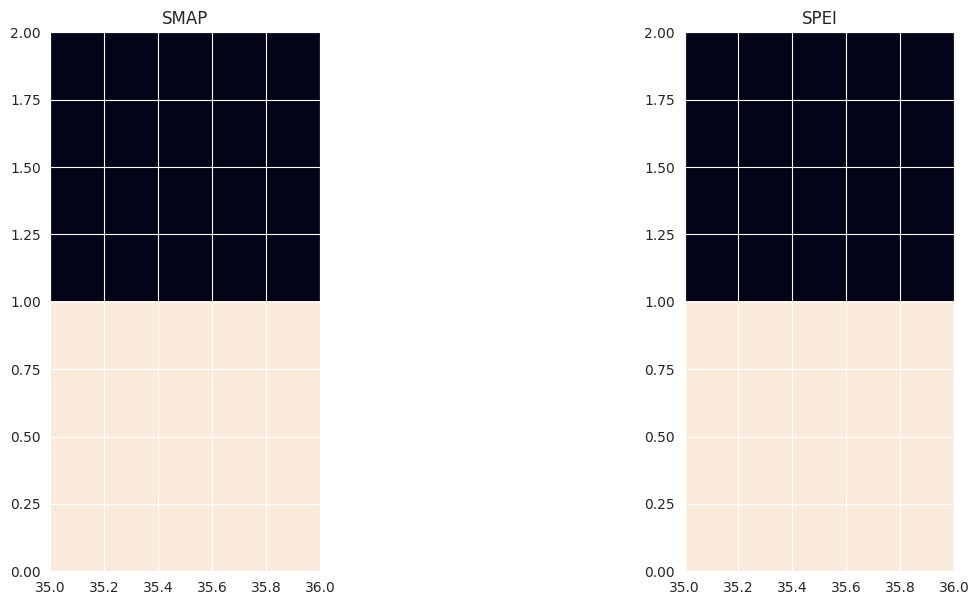

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

with rio.open(f"{data_raw}/raster/SMAP_mean.tif") as src:
    SMAP_mean_arr = src.read(1)
    SMAP_mean_meta = src.meta

with rio.open(f"{data_raw}/raster/SPEI_mean.tif") as src:
    SPEI_mean_arr = src.read(1)
    SPEI_mean_meta = src.meta

show(SMAP_mean_arr, ax=ax[0], transform=SMAP_mean_meta['transform'])
show(SPEI_mean_arr, ax=ax[1], transform=SPEI_mean_meta['transform'])

ax[0].set_title('SMAP')
ax[1].set_title('SPEI')

### Flood Hazard Exposure Raw Data
- Using WRI Aqueduct Floods Hazard Maps V2

In [7]:
GFH_mean = (ee.ImageCollection("JRC/CEMS_GLOFAS/FloodHazard/v1")
          .filterDate(date_48, date_now)
          .filterBounds(ee_EMC_bound.geometry())
          .select('depth')
          .mean())

geemap.ee_export_image(GFH_mean, region=ee_EMC_bound.geometry(), filename=f"{data_raw}/raster/GFH_mean.tif")

Generating URL ...
Please wait ...
Data downloaded to /home/chris/mnt1/Proj/amini-sa/data/01_raw/raster/GFH_mean.tif


Text(0.5, 1.0, 'GLOFAS')

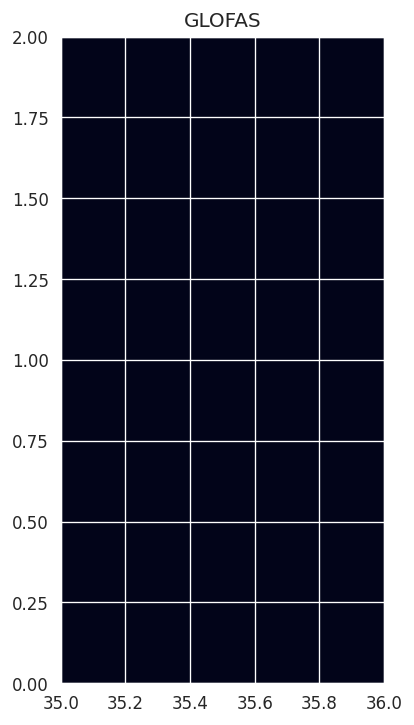

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

with rio.open(f"{data_raw}/raster/GFH_mean.tif") as src:
    GFH_mean_arr = src.read(1)
    GFH_mean_meta = src.meta

show(GFH_mean_arr, ax=ax, transform=GFH_mean_meta['transform'])
ax.set_title("GLOFAS")

### There seems to be a problem with GEE based global products where the extent is too large and the resolution is too low
I will now attempt to get higher resolution data from Humanitarian Data Exchange

### IGAD Region - Monthly Combined Drough Indicator 2024-25
https://data.humdata.org/dataset/igad-region-monthly-combined-drought-indicator-cdi-2024\
https://data.humdata.org/dataset/igad-region-monthly-combined-drought-indicator-cdi-2025

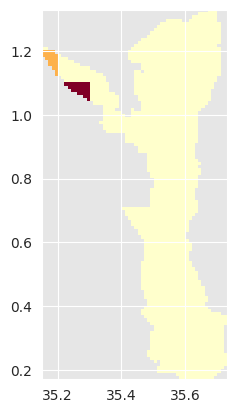

In [9]:
with rio.open(f"{data_raw}/raster/IGAD_CDI/eadw-cdi-data-2024-jun.tiff") as src:
    masked_data, out_transform = mask(src, EMC1_gpd.geometry, crop=True, nodata=np.nan, all_touched=True)
    show(masked_data[0], transform=out_transform, cmap='YlOrRd')

In [10]:
# Create new raster that combines the 2024 and 2025 data
all_cdi_arrays = []

# Loop through all CDI files
for cdi_file in sorted(glob(f"{data_raw}/raster/IGAD_CDI/*.tiff")):
    with rio.open(cdi_file, "r") as src:
        # Mask the raster to EMC boundary
        assert src.crs == EMC1_gpd.crs, "Raster and vector CRS do not match"
        masked_data, out_transform = mask(src, EMC1_gpd.geometry, crop=True, nodata=np.nan, all_touched=True)
        profile = src.profile

        profile.update({
            'driver': 'GTiff',
            'height': masked_data.shape[1],
            'width': masked_data.shape[2],
            'transform': out_transform,  # Use the new transform
            'dtype': np.float32,
            'nodata': np.nan
        })

        # Add masked data to our collection
        all_cdi_arrays.append(masked_data[0])

# There's 13 months of data, assert that it is true before calculation
assert len(all_cdi_arrays) == 13, "There's not 13 months of data"
# Check that all arrays have the same shape
shapes = [arr.shape for arr in all_cdi_arrays]
assert len(set(shapes)) == 1, "Arrays have different shapes"

cdi_stack = np.stack(all_cdi_arrays)
cdi_mean = np.nanmean(cdi_stack, axis=0)

# Save the mean CDI
os.makedirs(f"{data_features}/raster", exist_ok=True)
with rio.open(f"{data_features}/raster/EMC_CDI_mean.tif", 'w', **profile) as dst:
    dst.write(cdi_mean, 1)


/tmp/ipykernel_252112/1875923251.py:31: RuntimeWarning: Mean of empty slice
  cdi_mean = np.nanmean(cdi_stack, axis=0)


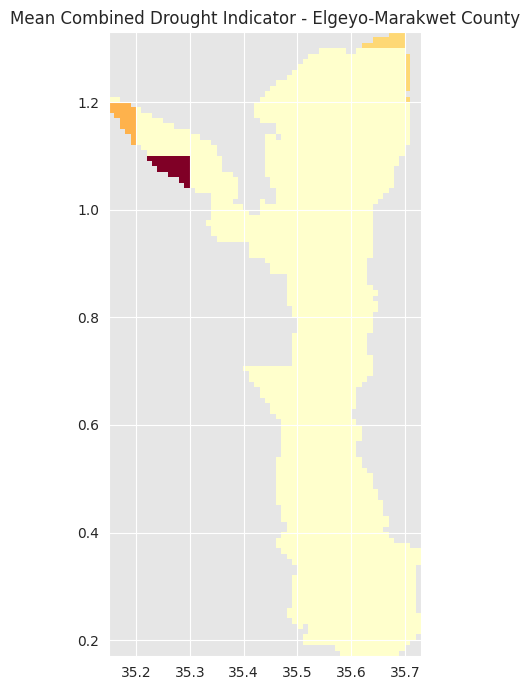

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

with rio.open(f"{data_features}/raster/EMC_CDI_mean.tif", "r") as src:
    EMC_drought, out_transform = src.read(1), src.transform

    # Show the masked data with the transform (not trying to access as dictionary)
    CDI_EMC = show(EMC_drought, ax=ax, transform=out_transform, cmap='YlOrRd')
    #cbar = fig.colorbar(CDI_EMC, ax=ax, orientation='vertical')
    ax.set_title('Mean Combined Drought Indicator - Elgeyo-Marakwet County')

os.makedirs("../docs/figures", exist_ok=True)
figure_path = Path("../docs/figures/")
plt.tight_layout()
plt.savefig(f"{figure_path}/MCDI_plot.png")
plt.show()

### Land Degradation Dataset
I would like to use ISDA soil fertility dataset from GEE, but it is not temporally up to date, iSDA API seems to be not returning results
Using GMES dataset instead https://gmesgeoportal.rcmrd.org/search?layout=grid&q=kenya%20land%20degradation&sort=Date%20Updated%7Cmodified%7Cdesc

> BTW TODAY IS 🥧 DAY :)

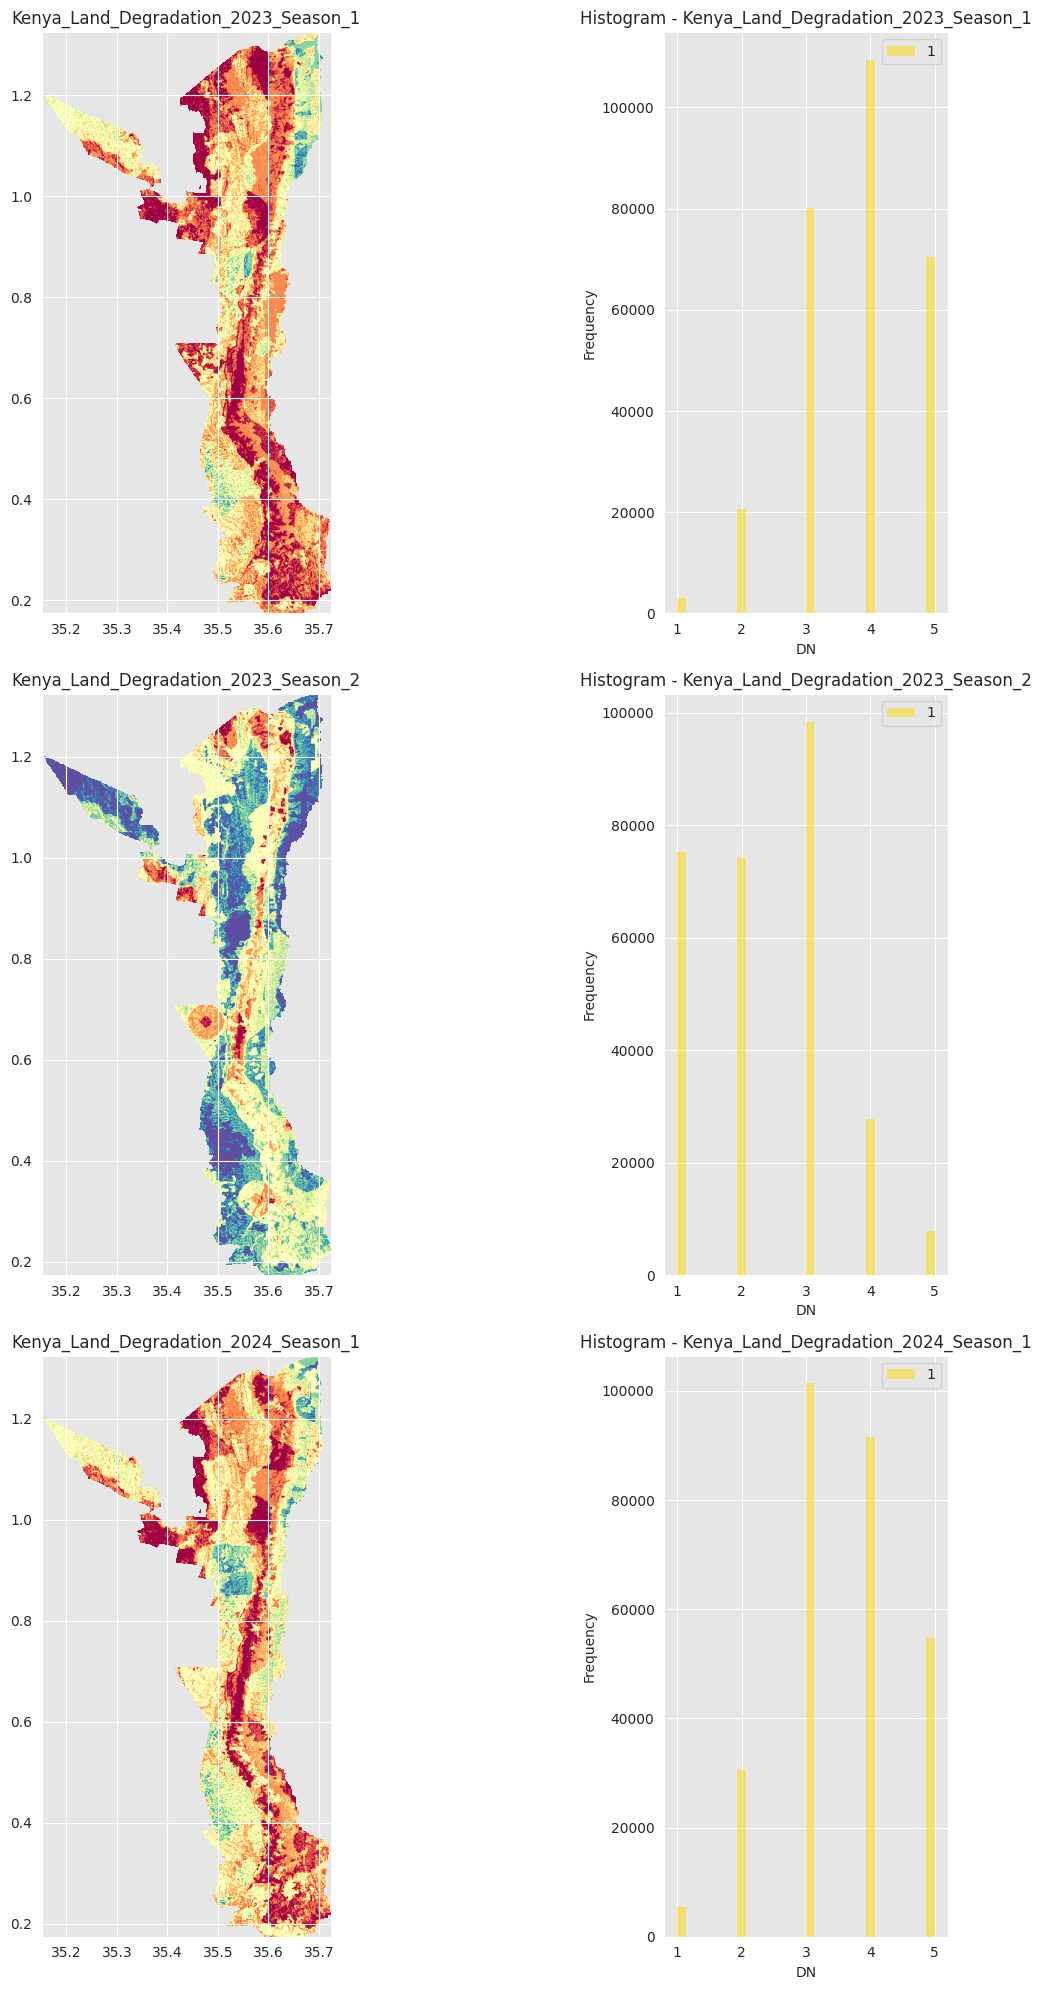

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15, 20), gridspec_kw={'width_ratios': [15, 3]})  # 3 rows, 2 columns

all_gmes_arrs = []

for i, file in enumerate(sorted(glob(f"{data_raw}/raster/RCMRD/*.tif"))):
    with rio.open(file, "r") as src:
        profile = src.profile

        assert src.crs == EMC1_gpd.crs, "Raster and vector CRS do not match"
        GMES_arr, out_transform = mask(src, EMC1_gpd.geometry, crop=True, all_touched=True)
        GMES_arr = GMES_arr[0].astype(np.float16)
        GMES_arr[GMES_arr == 127] = np.nan

        profile.update({
            'driver': 'GTiff',
            'height': GMES_arr.shape[0],
            'width': GMES_arr.shape[1],
            'transform': out_transform,  # Use the new transform
            'dtype': np.float32,
            'nodata': np.nan
        })

        all_gmes_arrs.append(GMES_arr)

        # Plot raster in left column
        show(GMES_arr, ax=ax[i,0], transform=out_transform, cmap='Spectral_r')
        ax[i, 0].set_title(Path(file).stem)

        # Plot histogram in right column
        show_hist(GMES_arr, ax=ax[i,1], bins=30, lw=0.0,
                  histtype='stepfilled', stacked=False, alpha=0.5)
        ax[i, 1].set_title(f"Histogram - {Path(file).stem}")

        # Write LD rasters
        path_str = Path(file).stem.split('_')
        with rio.open(f"{data_intermediate}/raster/EMC_LD_{path_str[3]}_{path_str[4]}_{path_str[5]}.tif", "w", **profile) as dst:
            dst.write(GMES_arr, 1)

plt.tight_layout()
plt.savefig(f"{figure_path}/GMES_LD_plots.png")
plt.show()

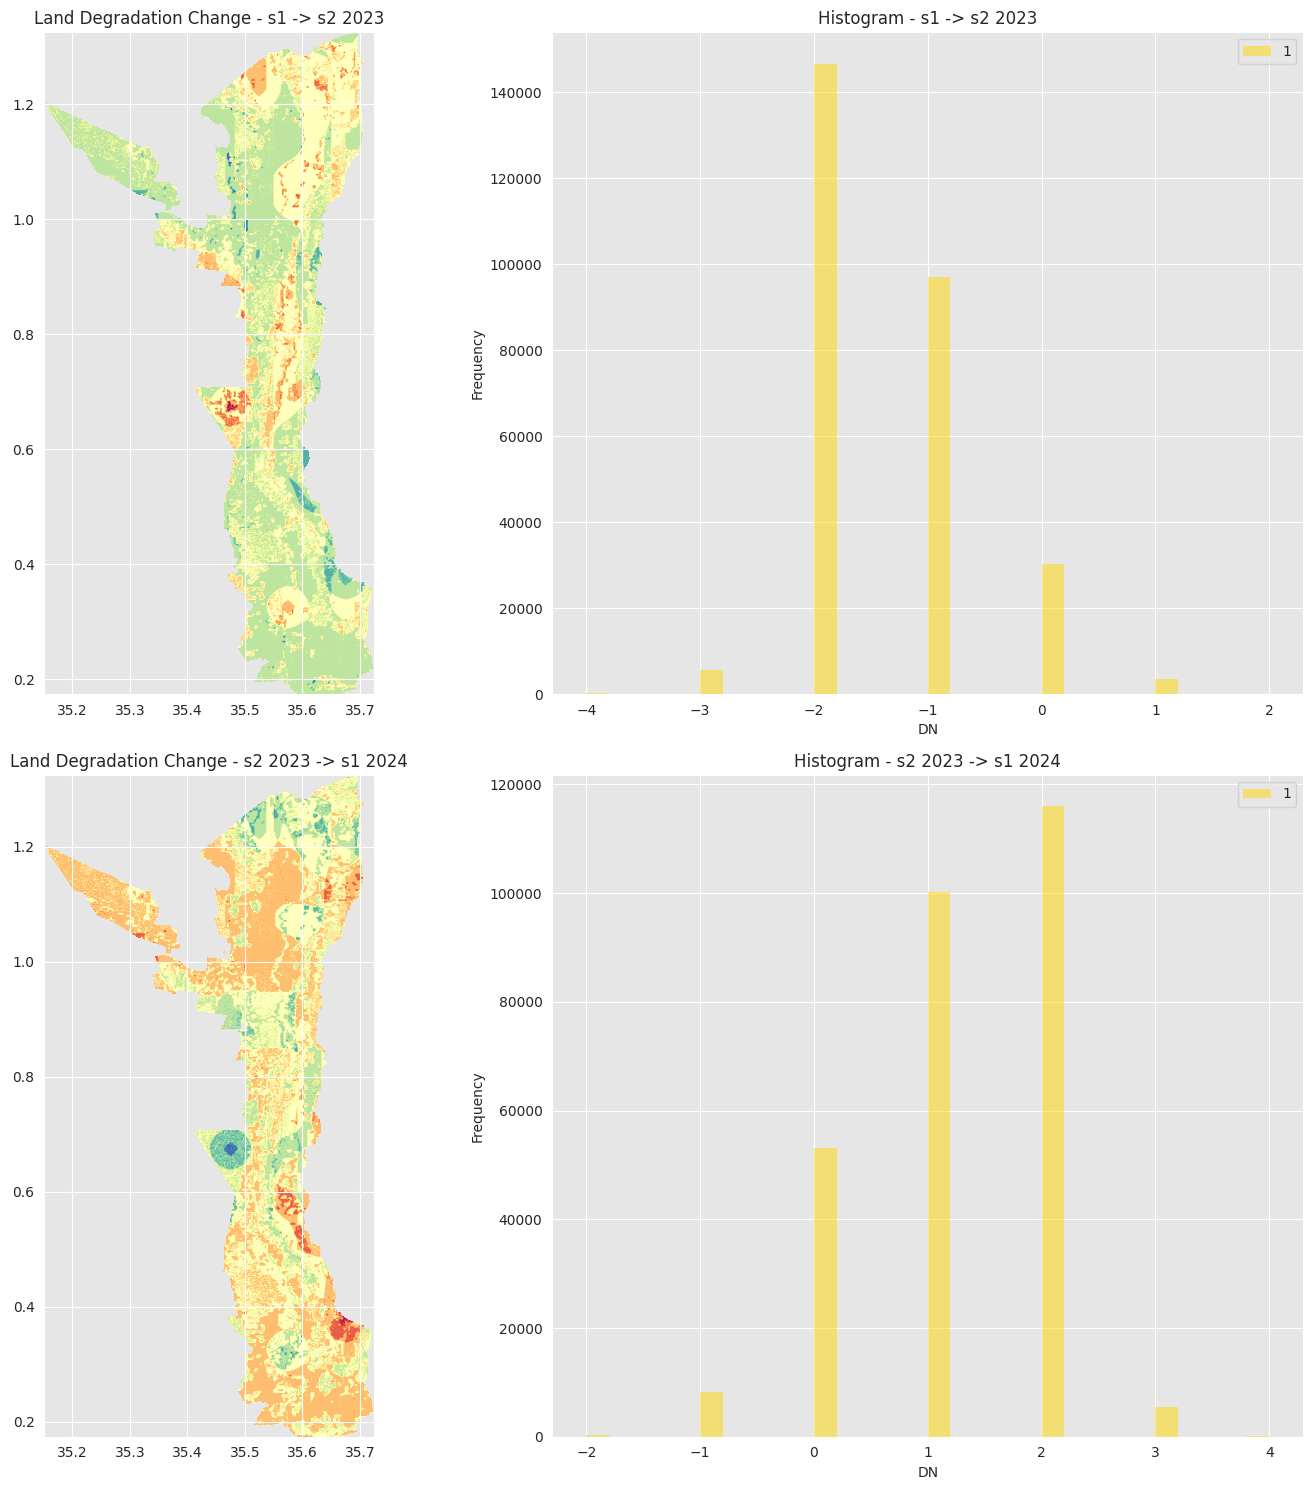

In [13]:
# Stack and compute Land Degradation Change
gmes_stack = np.stack(all_gmes_arrs)
s1s2_2023 = gmes_stack[1] - gmes_stack[0]
s22023_s12024 = gmes_stack[2] - gmes_stack[1]
LDC_arrs = [s1s2_2023, s22023_s12024]

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for i, LDC_arr in enumerate(LDC_arrs):
    show(LDC_arr, ax=ax[i,0], transform=out_transform, cmap='Spectral_r')

    show_hist(LDC_arr, ax=ax[i,1], bins=30, lw=0.0,
              histtype='stepfilled', stacked=False, alpha=0.5)

ax[0, 0].set_title('Land Degradation Change - s1 -> s2 2023')
ax[1, 0].set_title('Land Degradation Change - s2 2023 -> s1 2024')
ax[0, 1].set_title('Histogram - s1 -> s2 2023')
ax[1, 1].set_title('Histogram - s2 2023 -> s1 2024')

plt.tight_layout()
plt.savefig(f"{figure_path}/LDC_plots.png")
plt.show()

In [14]:
# Write LDC rasters output
# Use profile from GMES rasters
#with rio.open(f"{data_intermediate}/raster/EMC_LD_2023_Season_1.tif", "r") as src:
#    profile = src.profile
#
#    profile.update({
#        'driver': 'GTiff',
#        'height': LDC_arrs[0].shape[0],
#        'width': LDC_arrs[0].shape[1],
#        'transform': out_transform,  # Use the new transform
#        'dtype': np.float32,
#        'nodata': np.nan
#    })

with rio.open(f"{data_features}/raster/EMC_LDC_s12023s22023.tif", "w", **profile) as dst:
    dst.write(LDC_arrs[0], 1)
with rio.open(f"{data_features}/raster/EMC_LDC_s22023s12024.tif", "w", **profile) as dst:
    dst.write(LDC_arrs[1], 1)


### Flood Physical Exposre
- Once again, since GEE based global products are spatiall coarse, I found better resolution from RCMRD as the basis for flood physical exposure analysis
- Unfortunately, the RCMRD FPE dataset does not have a time component\
https://apps.rcmrd.org/atlases/elgeyo_marakwet/cdcontent.html

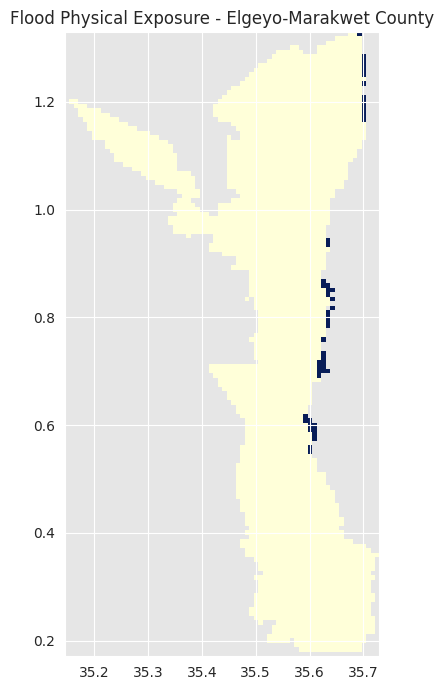

In [72]:
with rio.open(f"{data_raw}/raster/FPE_RCMRD/Flood Physical Exposure.tif") as src:
    assert src.crs == EMC1_gpd.crs, "Raster and vector CRS do not match"
    # Masking needed as the original FPE has a different extent than GADM41_KEN_3 EMC1_gpd
    FPE_arr, out_transform = mask(src, EMC1_gpd.geometry, crop=True, all_touched=True)
    profile = src.profile

    profile.update({
        'driver': 'GTiff',
        'height': FPE_arr.shape[1],
        'width': FPE_arr.shape[2],
        'transform': out_transform,  # Use the new transform
        'dtype': np.float32,
        'nodata': np.nan
    })

    FPE_arr = FPE_arr.astype(np.float16)
    FPE_arr[FPE_arr == 255] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
FRE_plot = show(FPE_arr, ax=ax, transform=out_transform, cmap='YlGnBu')
ax.set_title("Flood Physical Exposure - Elgeyo-Marakwet County")
plt.tight_layout()
plt.savefig(f"{figure_path}/FPE_plot.png")
plt.show()

In [16]:
print(LDC_arrs[0].shape)
print(cdi_mean.shape)
print(FPE_arr[0].shape)

(1276, 635)
(116, 58)
(139, 70)


In [17]:
with rio.open(f"{data_features}/raster/EMC_FPE.tif", "w", **profile) as dst:
    dst.write(FPE_arr[0], 1)


### Multiple Hazard Profile for gadm level 3
- Compute spatial statistics for each gadm level 3 regions


<Axes: >

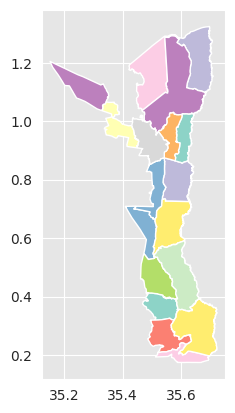

In [44]:
Kenya_GADM3 = gpd.read_file(f"{data_raw}/vector/gadm41_KEN_shp/gadm41_KEN_3.shp")
EMC_GADM3 = Kenya_GADM3[Kenya_GADM3['NAME_1'] == 'Elgeyo-Marakwet']
EMC_GADM3.to_file(f"{data_intermediate}/vector/EMC_GADM3.geojson", driver='GeoJSON')

EMC_GADM3 = gpd.read_file(f"{data_intermediate}/vector/EMC_GADM3.geojson")

EMC_GADM3.plot(column='NAME_3', cmap='Set3')

In [45]:
EMC_GADM3.sample(5)

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
10,KEN.5.3.1_1,KEN,Kenya,KEN.5_1,Elgeyo-Marakwet,NA,KEN.5.3_1,Marakwet East,NA,Endo,NA,NA,Ward,Ward,733,NA,"POLYGON ((35.69724 1.30042, 35.6973 1.30035, 3..."
11,KEN.5.3.2_1,KEN,Kenya,KEN.5_1,Elgeyo-Marakwet,NA,KEN.5.3_1,Marakwet East,NA,Kapyego,NA,NA,Ward,Ward,731,NA,"POLYGON ((35.59382 1.28579, 35.59285 1.28433, ..."
7,KEN.5.2.4_1,KEN,Kenya,KEN.5_1,Elgeyo-Marakwet,NA,KEN.5.2_1,Keiyo South,NA,Metkei,NA,NA,Ward,Ward,750,NA,"POLYGON ((35.69533 0.18275, 35.69417 0.18244, ..."
6,KEN.5.2.3_1,KEN,Kenya,KEN.5_1,Elgeyo-Marakwet,NA,KEN.5.2_1,Keiyo South,NA,Kaptarakwa,NA,NA,Ward,Ward,745,NA,"POLYGON ((35.47233 0.54684, 35.47292 0.54629, ..."
4,KEN.5.2.1_1,KEN,Kenya,KEN.5_1,Elgeyo-Marakwet,NA,KEN.5.2_1,Keiyo South,NA,Chepkorio,NA,NA,Ward,Ward,746,NA,"POLYGON ((35.57662 0.31919, 35.57647 0.31931, ..."


In [46]:
# Append the 3 classes of hazard exposure data to EMC_GADM3
def spatial_stats(gdf:gpd.GeoDataFrame, hazard_raster:str, hazard_type:str) -> gpd.GeoDataFrame:
    """
    Calculate zonal statistics for each polygon in the GeoDataFrame.
    
    Parameters:
    -----------
    gdf : GeoDataFrame with polygon geometries
    hazard_raster : Opened rasterio dataset
    hazard_type : Prefix for the new statistical columns
    
    Returns:
    --------
    GeoDataFrame with added statistical columns
    """
    result_gdf = gdf.copy()

    means = []
    medians = []
    stds = []

    # Read hazard raster from intermediate
    with rio.open(hazard_raster, 'r') as src:
        assert src.crs == gdf.crs, "Raster and vector CRS do not match"

        # Process each geometry
        for geom in gdf.geometry:
            try:
                # Mask the raster with the geometry
                masked_data, masked_transform = mask(src, [geom], crop=True, all_touched=True)

                # Get the valid data (excluding nodata values)
                means.append(np.nanmean(masked_data))
                medians.append(np.nanmedian(masked_data))
                stds.append(np.nanstd(masked_data))

            except Exception as e:
                print(f"Error processing geometry: {e}")
                means.append(np.nan)
                medians.append(np.nan)
                stds.append(np.nan)

    # Assign statistics to new columns
    result_gdf[f"{hazard_type}_mean"] = means
    result_gdf[f"{hazard_type}_median"] = medians
    result_gdf[f"{hazard_type}_std"] = stds

    return result_gdf

#### Combine all hazard exposure data into one dataframe

In [69]:
# CDI
EMC_LV3Hazard = spatial_stats(EMC_GADM3, f"{data_features}/raster/EMC_CDI_mean.tif", "CDI")
print(EMC_LV3Hazard[["NAME_3", "CDI_mean", "CDI_median", "CDI_std"]])

# FPE
EMC_LV3Hazard = spatial_stats(EMC_LV3Hazard, f"{data_features}/raster/EMC_FPE.tif", "FPE")
print(EMC_LV3Hazard[["NAME_3", "FPE_mean", "FPE_median", "FPE_std"]])

# Land Degradation
EMC_LV3Hazard = spatial_stats(EMC_LV3Hazard, f"{data_intermediate}/raster/EMC_LD_2023_Season_1.tif", "LD2023_S1")
EMC_LV3Hazard = spatial_stats(EMC_LV3Hazard, f"{data_intermediate}/raster/EMC_LD_2023_Season_2.tif", "LD2023_S2")
EMC_LV3Hazard = spatial_stats(EMC_LV3Hazard, f"{data_intermediate}/raster/EMC_LD_2024_Season_1.tif", "LD2024_S1")
print(EMC_LV3Hazard[["NAME_3", "LD2023_S1_mean", "LD2023_S1_median", "LD2023_S1_std",
                     "LD2023_S2_mean", "LD2023_S2_median", "LD2023_S2_std",
                     "LD2024_S1_mean", "LD2024_S1_median", "LD2024_S1_std"]])

# Land Degradation Change
EMC_LV3Hazard = spatial_stats(EMC_LV3Hazard, f"{data_features}/raster/EMC_LDC_s12023s22023.tif", "LDC_s1_2023_s2_2023")
print(EMC_LV3Hazard[["NAME_3", "LDC_s1_2023_s2_2023_mean", "LDC_s1_2023_s2_2023_median", "LDC_s1_2023_s2_2023_std"]])
EMC_LV3Hazard = spatial_stats(EMC_LV3Hazard, f"{data_features}/raster/EMC_LDC_s22023s12024.tif", "LDC_s2_2023_s1_2024")
print(EMC_LV3Hazard[["NAME_3", "LDC_s2_2023_s1_2024_mean", "LDC_s2_2023_s1_2024_median", "LDC_s2_2023_s1_2024_std"]])

                    NAME_3  CDI_mean  CDI_median   CDI_std
0                    Emsoo  0.000000         0.0  0.000000
1                 Kamariny  0.000000         0.0  0.000000
2              Kapchemutwa  0.000000         0.0  0.000000
3                  Tambach  0.000000         0.0  0.000000
4                Chepkorio  0.000000         0.0  0.000000
5                 Kabiemit  0.000000         0.0  0.000000
6               Kaptarakwa  0.000000         0.0  0.000000
7                   Metkei  0.000000         0.0  0.000000
8                Soy North  0.000000         0.0  0.000000
9                Soy South  0.000000         0.0  0.000000
10                    Endo  0.018580         0.0  0.050133
11                 Kapyego  0.000000         0.0  0.000000
12                Sambirir  0.000000         0.0  0.000000
13                   Arror  0.000000         0.0  0.000000
14  Cherang'Any/Chebororwa  0.000000         0.0  0.000000
15                Kapsowar  0.000000         0.0  0.0000

In [70]:
pd.concat([EMC_LV3Hazard[["NAME_3"]], EMC_LV3Hazard.iloc[:, 16:]], axis=1)
EMC_LV3Hazard.to_parquet("../data/07_model_output/EMC_LV3Hazard.parquet", engine="pyarrow")

#### Kepler.GL

In [87]:
import webbrowser

new=2
webbrowser.open("../docs/kepler.gl.html", new=new)

True